# **Initial Setups**

## **Set MSCTD Configurations**

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip3 install --upgrade gdown
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade --no-cache-dir gdown

!git clone https://github.com/XL2248/MSCTD

!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment*.txt .

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'MSCTD' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install einops
!pip install pytorch_lightning
!pip install wandb
!pip install ml_collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Import Libraries**

In [3]:
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cv2
from tqdm import tqdm
from time import localtime
from numpy import asarray
import random
import gc

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output 
from itertools import chain
from tensorflow.keras.preprocessing.text import Tokenizer

# import pytorch_lightning as pl
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
# from matplotlib import image as mpimg
# from PIL import Image
# from PIL import Image, ImageOps, ImageEnhance
# from einops import parse_shape, rearrange
# from opt_einsum import contract
# import math
# import functools
import pickle, marshal
# from einops import rearrange

# libraries for text processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('stopwords')

!pip install transformers

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from torch.optim import Adam, SGD
from transformers import get_linear_schedule_with_warmup

import torch.nn.functional as F

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Device Configuration**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Create Data Loader Class**

## **Training Functions**

In [5]:
def score(y_true, y_pred, average='weighted'):
    return [(y_true == y_pred).mean(), f1_score(y_true, y_pred, average=average)]

def loss_and_target(y_true, y_pred, losses):
    y = [torch.stack(y_true).cpu().detach().numpy(),
         torch.stack(y_pred).cpu().detach().numpy()]
    loss = np.mean(losses)
    return y, loss


def get_min_loss(model, step, train_score, train_loss, valid_score, loss_val,
                 minimum_loss, epoch, epochs, output_path, total_steps):

    print('{}%' .format(round(step/total_steps * 100, 2)))
    print('Epoch: {}/{}\n' .format(epoch, epochs))
    print('Train Loss: {:.4f}    Train Acc: {:.3f}\n'.format(train_loss, train_score[0]))
    print('Valid Loss: {:.4f}    Valid Acc: {:.3f}\n'.format(loss_val, valid_score[0]))

    if loss_val <= minimum_loss:
        print('Val Loss Decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(minimum_loss, loss_val))
        
        torch.save(model.state_dict(), output_path)
        minimum_loss = loss_val

    return minimum_loss


def evaluate_model(model, data_loader, criterion):

    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():

        for data in tqdm(data_loader, total=len(data_loader), desc="Evaluation"):
            
            input_ids = data['input_ids']
            attention_mask = data['attention_mask']
            token_type_ids = data['token_type_ids']
            targets = data['targets']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, targets)
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, loss_val = loss_and_target(y_true, y_pred, losses)
    return eval_y, loss_val


def train_model(model, data_loader, criterion, optimizer, scheduler, step=0,
          eval=False, minimum_loss=np.Inf, eval_data_loader=None, epoch=0,
          epochs=3, output_path=None):
    
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for data in tqdm(data_loader, total=len(data_loader), desc="Training"):

        step += 1

        input_ids = data['input_ids']
        attention_mask = data['attention_mask']
        token_type_ids = data['token_type_ids']
        targets = data['targets']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                        token_type_ids=token_type_ids)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:

            train_y, train_loss = loss_and_target(y_true, y_pred, losses)
            train_score = score(train_y[0], train_y[1], average='weighted')

            if step % 500 == 0:
                eval_y, loss_val = evaluate_model(model, eval_data_loader, criterion)
                valid_score = score(eval_y[0], eval_y[1], average='weighted')

                if hasattr(get_min_loss, '__call__'):
                    minimum_loss = get_min_loss(model, step, train_score,
                    train_loss, valid_score, loss_val, minimum_loss, epoch,
                     EPOCHS, output_path, total_steps)

    train_y, train_loss = loss_and_target(y_true, y_pred, losses)

    return train_y, train_loss, step, minimum_loss


def predict(model, targets, tokenizer, max_len, batch_size=32):

    dataset_p = Dataset(tokenizer, targets, None, None, max_len)
    data_loader = torch.utils.data.DataLoader(dataset_p, batch_size=batch_size)
    
    predictions = []
    prediction_probs = []

    
    model.eval()
    with torch.no_grad():
        for dl in data_loader:
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
            
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

## Import Dataset and Create Dataset Object

In [6]:
classes = ['Neutral', 'Negative', 'Positive']

# **Loading Text Model and Image Model**

In [7]:
class ClassifierModel(nn.Module):

    def __init__(self, config):
        super(ClassifierModel, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids,
            return_dict=False)
        return self.classifier(self.dropout(pooled_output))

In [36]:
path_image_model = F"/content/drive/MyDrive/phase3/best_image_model" 
path_text_model = F"/content/drive/MyDrive/phase3/best_text_model" 
image_model = torch.load(path_image_model)
text_model = torch.load(path_text_model)

# **Text Dataset**

In [9]:
def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

## **Preparing Unlabeled Dataset**

In [10]:
!gdown --id '1Rv6CFwDGwiVjozO5JXdiIXeVKmnJR1RL'

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Rv6CFwDGwiVjozO5JXdiIXeVKmnJR1RL
To: /content/test.origin.txt
100% 1.67M/1.67M [00:00<00:00, 142MB/s]


In [11]:
my_file = open('/content/test.origin.txt', "r")
data = my_file.read()
dialogues = data.split("\n")
dialogues = np.array(dialogues)
len_dataset = len(dialogues)

In [12]:
for i in range(5):
    s = dialogues[i + 300]
    print('Row Text:')
    print(s)
    text = preprocess_text(s, remove_stopwords=False)
    print('\nPreprocessed Text:')
    print(text)
    print('\n')

Row Text:
Thank you.

Preprocessed Text:
thank you


Row Text:
Yeah. ‘Yeah.

Preprocessed Text:
yeah yeah


Row Text:
Smell you later, pal.

Preprocessed Text:
smell you later pal


Row Text:
Hey, Coop.

Preprocessed Text:
hey coop


Row Text:
What? why?

Preprocessed Text:
what why




In [13]:
def get_clean_text(documents):
    texts = []
    for i in tqdm(range(len(documents))):
        text = preprocess_text(documents[i], remove_stopwords=False)
        texts.append(text)
    return texts

In [14]:
dialogues_sample = dialogues[:12001]

In [15]:
test_texts = get_clean_text(dialogues_sample)

  0%|          | 0/12001 [00:00<?, ?it/s]

In [16]:
max_len = max(len(text.split(' ')) for text in test_texts)
max_len

20

In [17]:
dict1 = {'dialoges': test_texts, 'targets': None}  
test = pd.DataFrame(dict1)
test.head(10)

,dialoges,targets
0,then you will not,None
1,you know what i m not going down like this,None
2,i need you to untie me,None
3,julst untie me,None
4,no you heard mr fine he s working a plan,None
5,we have to stay put,None
6,that s my ass,None
7,it is very difficult to see or gauge my position,None
8,you re just simply grabbing my ass,None
9,qh i am sorry,None


In [18]:
path_unlabeled_model = '/content/Emotion_Classification_Unlabeled/pytorch_model.bin'
os.makedirs(os.path.dirname(path_unlabeled_model), exist_ok=True)

label_map = ['neutral', 'negative', 'positive']
label2id = {label: i for i, label in enumerate(label_map)}
id2label = {v: k for k, v in label2id.items()}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

config = BertConfig.from_pretrained(
    'bert-base-uncased', **{
        'label2id': label2id,
        'id2label': id2label,
    })

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, dialoge_texts, targets=None, labels=None, max_len=max_len):
        self.dialoge_texts = dialoge_texts
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)
        self.label_map = {label: i for i, label in enumerate(labels)} if isinstance(labels, list) else {}
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.dialoge_texts)

    def __getitem__(self, item):
        dialoge_text = self.dialoge_texts[item]

        if self.has_target:
            target = self.label_map.get(self.targets[item], self.targets[item])
        encoding = self.tokenizer.encode_plus(
            dialoge_text, add_special_tokens=True, truncation=True, max_length=self.max_len, return_token_type_ids=True,
            padding='max_length', return_attention_mask=True, return_tensors='pt')
        
        inputs = { 'dialoge_text': dialoge_text, 'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(), 'token_type_ids': encoding['token_type_ids'].flatten(),}

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
            
        return inputs

In [20]:
batch_size = 16
test_dataset = Dataset(tokenizer, test['dialoges'].to_numpy(), None, label_map, max_len)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

## **Getting Label From Text Model**

In [21]:
test_dialoges = test['dialoges'].to_numpy()
y_pred, probs = predict(text_model, test_dialoges, tokenizer, max_len=max_len)
new_labels = y_pred
logits_teacher = probs

# **Image Based Model**

## **preparing dataset**

In [22]:
class Unlabeled_Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, labels, test_dialoges, image_size, batch_size=None):
    'Initialization'
    self.image_size = image_size
    self.batch_size = batch_size
    self.dialoges = test_dialoges
    self.labels = labels

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.labels)

  def __getitem__(self, index):
    'Generates one sample of data'
    image_index = self.get_image(index)
    label_index = self.labels[index]
    text_index = self.dialoges[index]
    return image_index, label_index

  def get_image(self, index):
    file_name = '/content/drive/MyDrive/phase3/unlabeled/' + str(index) + '.jpg'
    image = cv2.imread(file_name)
    image= np.asarray(image)
    return image

In [23]:
data_loader = Unlabeled_Dataset(labels=new_labels, test_dialoges=test_dialoges, image_size=(554,1280), batch_size=64)

In [24]:
def plot_random_frames(path, L):
    r = np.random.randint(0, L, 9)
    plt.figure(figsize=(16, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        image = cv2.imread(path + str(r[i]) + '.jpg')
        image= np.asarray(image)
        plt.imshow(image)

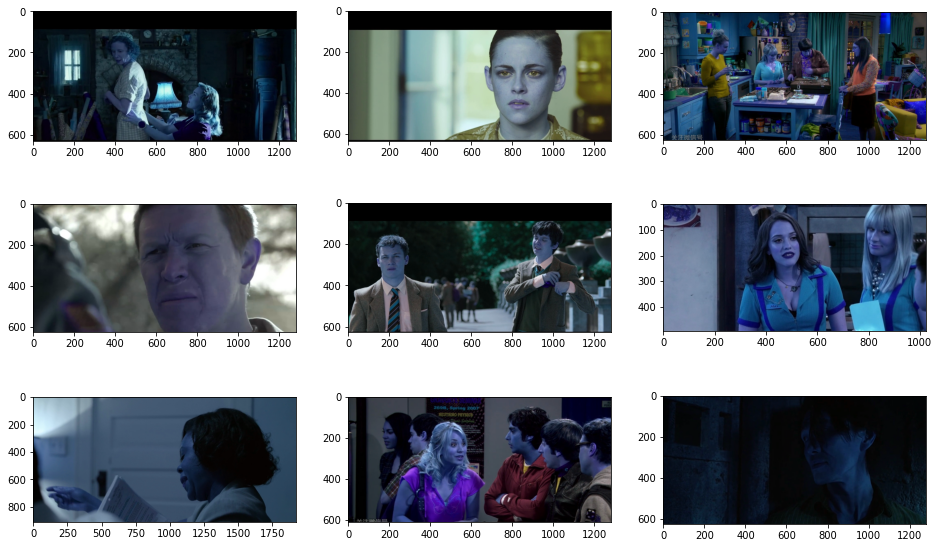

In [25]:
plot_random_frames('/content/drive/MyDrive/phase3/unlabeled/', 12000)

In [26]:
def get_data(data_loader: Dataset, size, frame_size = (128, 128), skip=1):
    labels = []
    frames = []
    for i in tqdm(range(size)):
        try:
            frame, label = data_loader.__getitem__(i)
            frames.append(cv2.resize(frame, dsize = frame_size).astype('float32'))
            labels.append(label)
        except Exception as e:
            print(i)
    return frames , labels

In [27]:
train_frames, train_labels = get_data(data_loader, size=7000)

  0%|          | 0/7000 [00:00<?, ?it/s]

In [28]:
print(train_frames[0].shape)

train_frames_r = np.zeros((len(train_frames), 3, 128 , 128))

if train_frames[0].shape[2] == 3:
    for i in range(len(train_frames)):
        train_frames_r[i] = train_frames[i].T

print(train_frames_r[0].shape)

x_train = torch.tensor(np.array(train_frames_r), dtype=torch.float32)
y_train = torch.tensor(train_labels).type(torch.LongTensor)

train_set = list(map(lambda x, text, y: (x, text, y), x_train, test_dialoges, y_train))
train_loader = torch.utils.data.DataLoader(train_set[:4000], batch_size=64, shuffle=True, num_workers=2 )
val_loader = torch.utils.data.DataLoader(train_set[4000:6000], batch_size=64, shuffle=True, num_workers=2 )
test_loader = torch.utils.data.DataLoader(train_set[6000:], batch_size=64, shuffle=True, num_workers=2 )

(128, 128, 3)
(3, 128, 128)


In [29]:
import torch.nn.functional as F
def distiller_criterion(y_pred, y_true, y_pred_teacher, params):
    alpha, tau = params
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, y_true)
    teacher_pred = F.softmax(y_pred_teacher / tau, dim=1)
    student_pred = F.softmax(y_pred / tau, dim=1)
    distiller_loss = - (teacher_pred * torch.log(student_pred)).sum(axis=1).mean()
    return (1 - alpha) * loss + alpha * (tau ** 2) * distiller_loss

In [44]:
def train_epoch(net, criterion, optimizer, dataloader, tokenizer, max_len, teacher_model=None, params=None):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  train_loss = 0
  train_accuracy = 0
  i = 0

  net.train()
  for i, (x, text, y) in enumerate(tqdm(dataloader)):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    if teacher_model is not None:
        _, probs = predict(teacher_model, text, tokenizer, max_len=max_len)
        p_t = torch.tensor(probs, device=device)
        loss = criterion(p, y, p_t, params)
    else:
        loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()
    
    train_loss = epoch_loss / (i + 1)
    train_accuracy = epoch_true / epoch_all

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss, train_accuracy


def evaluate_epoch(net, criterion, dataloader, tokenizer, max_len, teacher_model=None, params=None):
  epoch_loss = 0
  epoch_true = 0
  epoch_all = 0
  eval_loss = 0
  eval_accuracy = 0
  i = 0

  net.eval()
  for i, (x, text, y) in enumerate(dataloader):
    x = x.to(device)
    y = y.to(device)
    p = net(x)

    if teacher_model is not None:
        _, probs = predict(teacher_model, text, tokenizer, max_len=max_len)
        p_t = torch.tensor(probs, device=device)
        loss = criterion(p, y, p_t, params)
    else:
        loss = criterion(p, y)
    epoch_loss += float(loss)

    predictions = p.argmax(-1)
    epoch_all += len(predictions)
    epoch_true += (predictions == y).sum()

    eval_loss = epoch_loss / (i + 1)
    eval_accuracy = epoch_true / epoch_all

  return eval_loss, eval_accuracy


def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)


def train_model(net, n_epochs, criterion, optimizer, train_loader, tokenizer, max_len, val_loader=None, teacher_model=None, params=None):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    max_test_acc = 0
    name = 'model.pth'

    for e in range(n_epochs):
        if teacher_model is not None:
            train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader, tokenizer, max_len, teacher_model, params)
            if val_loader is not None:
                val_loss, val_accuracy = evaluate_epoch(net, criterion, val_loader, tokenizer, max_len, teacher_model, params)
                if float(val_accuracy) > max_test_acc:
                    print("val accuracy increased. saving model...")
                    max_test_acc = float(val_accuracy)
                    torch.save(net, name)
        else:
            train_loss, train_accuracy = train_epoch(net, criterion, optimizer, train_loader)
            if val_loader is not None:
                val_loss, val_accuracy = evaluate_epoch(net, criterion, val_loader)
        

        train_losses.append(train_loss)
        train_accuracies.append(float(train_accuracy))
        if val_loader is not None:
            val_losses.append(val_loss)
            val_accuracies.append(float(val_accuracy))

        print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
        print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
        if val_loader is not None:
            print(f'Validation Loss: {val_loss:.4f}\t\tValidation Accuracy: {val_accuracy:.2f}')
        else:
            print()
    
    return train_losses, train_accuracies, val_losses, val_accuracies


def test_model(net, criterion, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    eval_loss = 0
    eval_accuracy = 0
    i = 0
    with torch.no_grad():
        pred = torch.tensor([]) #.to(device)

        net_cpu = net.to('cpu')
        net.eval()
        for i, (x, text, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            
            p = net(x)
            # y_hat = torch.cat((y_hat, p), 0)
            
            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            eval_loss = epoch_loss / (i + 1)
            eval_accuracy = epoch_true / epoch_all

            pred = torch.cat((pred, predictions), 0)

    return pred, eval_loss, eval_accuracy

In [38]:
image_model = image_model.to(device)
optimizer = SGD(image_model.fc.parameters(), lr=0.001, momentum=0.9)

best_tau, best_alpha = (0.5, 15)

train_loss, train_acc, test_loss, test_acc = train_model(
    image_model, 15, distiller_criterion, optimizer,
    train_loader, tokenizer, max_len, val_loader, text_model, (best_tau, best_alpha)
)

  0%|          | 0/63 [00:00<?, ?it/s]

val accuracy increased. saving model...
[Epoch 1]	 [1:20:43]	Train Loss: 124.1533	Train Accuracy: 0.40	Validation Loss: 124.1480		Validation Accuracy: 0.40


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 2]	 [1:20:58]	Train Loss: 124.1354	Train Accuracy: 0.44	Validation Loss: 124.1432		Validation Accuracy: 0.40


  0%|          | 0/63 [00:00<?, ?it/s]

val accuracy increased. saving model...
[Epoch 3]	 [1:21:14]	Train Loss: 124.1289	Train Accuracy: 0.45	Validation Loss: 124.1429		Validation Accuracy: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 4]	 [1:21:29]	Train Loss: 124.1251	Train Accuracy: 0.47	Validation Loss: 124.1424		Validation Accuracy: 0.41


  0%|          | 0/63 [00:00<?, ?it/s]

val accuracy increased. saving model...
[Epoch 5]	 [1:21:44]	Train Loss: 124.1245	Train Accuracy: 0.47	Validation Loss: 124.1544		Validation Accuracy: 0.43


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 6]	 [1:21:59]	Train Loss: 124.1205	Train Accuracy: 0.49	Validation Loss: 124.1557		Validation Accuracy: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 7]	 [1:22:14]	Train Loss: 124.1197	Train Accuracy: 0.49	Validation Loss: 124.1441		Validation Accuracy: 0.41


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 8]	 [1:22:29]	Train Loss: 124.1156	Train Accuracy: 0.50	Validation Loss: 124.1480		Validation Accuracy: 0.43


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 9]	 [1:22:44]	Train Loss: 124.1151	Train Accuracy: 0.50	Validation Loss: 124.1489		Validation Accuracy: 0.39


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 10]	 [1:22:59]	Train Loss: 124.1146	Train Accuracy: 0.50	Validation Loss: 124.1462		Validation Accuracy: 0.40


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 11]	 [1:23:15]	Train Loss: 124.1169	Train Accuracy: 0.50	Validation Loss: 124.1588		Validation Accuracy: 0.37


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 12]	 [1:23:30]	Train Loss: 124.1123	Train Accuracy: 0.50	Validation Loss: 124.1487		Validation Accuracy: 0.41


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 13]	 [1:23:45]	Train Loss: 124.1139	Train Accuracy: 0.51	Validation Loss: 124.1498		Validation Accuracy: 0.39


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 14]	 [1:24:0]	Train Loss: 124.1126	Train Accuracy: 0.51	Validation Loss: 124.1484		Validation Accuracy: 0.40


  0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 15]	 [1:24:15]	Train Loss: 124.1088	Train Accuracy: 0.52	Validation Loss: 124.1512		Validation Accuracy: 0.38


In [63]:
net = torch.load('model.pth')
test_loss, test_accuracy = evaluate_epoch(net, distiller_criterion, test_loader, tokenizer, max_len, text_model, (best_tau, best_alpha))
print(f'accuracy: {test_accuracy:.3f}')

accuracy: 0.456


In [64]:
drive_path = F"/content/drive/MyDrive/best_adopted_model" 
torch.save(image_model, drive_path)